# Masked Image Modelling

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import logging
import os
import os.path as osp
from collections import defaultdict
from dataclasses import dataclass
from functools import partial
from pathlib import Path
from typing import Callable, List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from lightning.pytorch import LightningModule
from lion_pytorch import Lion
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import (
    Compose,
    Lambda,
    Normalize,
    RandomCrop,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
)
from torchvision.transforms.functional import InterpolationMode
from transformers import (
    HfArgumentParser,
    Trainer,
    TrainingArguments,
    ViTImageProcessor,
    ViTMAEConfig,
    ViTMAEForPreTraining,
)

from src.mae.module import MAEDatasetConfig, MAEModule, MAEOptimizerConfig
from src.modules.transforms import ComplexTransform, SimpleTransform
from src.modules.transforms.color_jitter import ColorJitterPerChannel

In [8]:
for i in range(1, 4):
    if not Path(f"../cpjump{i}/jump/").exists():
        print(f"Mounting cpjump{i}...")
        os.system(f"sshfs bioclust:/projects/cpjump{i}/ ../cpjump{i}")
    else:
        print(f"cpjump{i} already mounted.")

cpjump1 already mounted.
cpjump2 already mounted.
cpjump3 already mounted.


## Dataset

In [21]:
root_dir = "../cpjump1/"
rxrx_dir = osp.join(root_dir, "rxrx1")
jump_dir = osp.join(root_dir, "jump")

print(osp.exists(root_dir), osp.exists(rxrx_dir), osp.exists(jump_dir))

True True True


In [22]:
rx_meta = pd.read_csv(osp.join(rxrx_dir, "metadata.csv"))

In [23]:
rx_meta

,site_id,well_id,cell_type,dataset,experiment,plate,well,site,well_type,sirna,sirna_id
0,HEPG2-08_1_B02_1,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,1,negative_control,EMPTY,1138
1,HEPG2-08_1_B02_2,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,2,negative_control,EMPTY,1138
2,HEPG2-08_1_B03_1,HEPG2-08_1_B03,HEPG2,test,HEPG2-08,1,B03,1,treatment,s21721,855
3,HEPG2-08_1_B03_2,HEPG2-08_1_B03,HEPG2,test,HEPG2-08,1,B03,2,treatment,s21721,855
4,HEPG2-08_1_B04_1,HEPG2-08_1_B04,HEPG2,test,HEPG2-08,1,B04,1,treatment,s20894,710
...,...,...,...,...,...,...,...,...,...,...,...
125505,U2OS-03_4_O21_2,U2OS-03_4_O21,U2OS,train,U2OS-03,4,O21,2,treatment,s20367,824
125506,U2OS-03_4_O22_1,U2OS-03_4_O22,U2OS,train,U2OS-03,4,O22,1,treatment,s195079,328
125507,U2OS-03_4_O22_2,U2OS-03_4_O22,U2OS,train,U2OS-03,4,O22,2,treatment,s195079,328
125508,U2OS-03_4_O23_1,U2OS-03_4_O23,U2OS,train,U2OS-03,4,O23,1,treatment,s21454,509


In [11]:
os.listdir(Path(rxrx_dir) / "images" / "HUVEC-15" / "Plate1")

['M17_s2_w5.png',
 'G05_s1_w4.png',
 'M02_s1_w4.png',
 'C03_s1_w4.png',
 'L10_s2_w3.png',
 'B16_s2_w6.png',
 'J17_s2_w1.png',
 'H17_s2_w2.png',
 'O02_s2_w2.png',
 'L13_s1_w1.png',
 'L14_s1_w6.png',
 'C23_s1_w2.png',
 'I13_s2_w3.png',
 'C22_s1_w1.png',
 'B21_s1_w6.png',
 'D19_s2_w1.png',
 'G17_s2_w2.png',
 'D15_s1_w5.png',
 'G12_s2_w4.png',
 'B09_s2_w1.png',
 'N02_s1_w2.png',
 'M22_s2_w2.png',
 'J16_s1_w6.png',
 'H16_s2_w5.png',
 'N16_s2_w4.png',
 'K13_s2_w6.png',
 'F06_s1_w2.png',
 'B23_s2_w2.png',
 'D05_s2_w6.png',
 'D04_s2_w5.png',
 'H12_s1_w5.png',
 'G14_s2_w6.png',
 'M03_s1_w5.png',
 'C04_s1_w4.png',
 'C18_s2_w5.png',
 'I20_s1_w3.png',
 'C13_s1_w1.png',
 'E10_s1_w6.png',
 'B12_s2_w1.png',
 'D08_s1_w1.png',
 'G08_s1_w5.png',
 'H06_s1_w6.png',
 'E14_s1_w5.png',
 'B09_s1_w5.png',
 'I06_s2_w6.png',
 'H18_s1_w3.png',
 'C16_s1_w2.png',
 'D12_s2_w1.png',
 'K20_s2_w1.png',
 'D05_s2_w5.png',
 'L11_s2_w4.png',
 'N19_s1_w1.png',
 'I04_s1_w5.png',
 'E05_s1_w5.png',
 'D03_s1_w5.png',
 'H22_s2_w

In [24]:
imgs = list((Path(rxrx_dir)).rglob("*.png"))

In [25]:
len(imgs)

753060

In [34]:
def img_path_to_view_and_channel(path):
    path = str(path)
    channel = path.split("_")[-1].split(".")[0]
    view = "__".join("__".join(path.split("_")[:-1]).split("/")[-3:])
    return view, channel

In [43]:
img_dict = defaultdict(dict)
for img in imgs:
    view, channel = img_path_to_view_and_channel(img)
    new_img = str(img).replace("../", "/projects/")
    img_dict[channel][view] = new_img

In [45]:
load_df = pd.DataFrame(img_dict)
load_df

,w5,w4,w3,w6,w1,w2
HUVEC-09__Plate3__M17__s2,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...
HUVEC-09__Plate3__D15__s1,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...
HUVEC-09__Plate3__H16__s2,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...
HUVEC-09__Plate3__D04__s2,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...
HUVEC-09__Plate3__H12__s1,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...
...,...,...,...,...,...,...
RPE-02__Plate2__F11__s2,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/F...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/F...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/F...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/F...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/F...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/F...
RPE-02__Plate2__L02__s1,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...
RPE-02__Plate2__I14__s1,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/I...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/I...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/I...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/I...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/I...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/I...
RPE-02__Plate2__L21__s2,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...


In [46]:
idx = load_df.index.str.split("__", expand=True).to_frame()
cell = idx[0].values
plate = idx[1].values
well = idx[2].values
site = idx[3].values
load_df = load_df.assign(cell=cell, plate=plate, well=well, site=site)
load_df

,w5,w4,w3,w6,w1,w2,cell,plate,well,site
HUVEC-09__Plate3__M17__s2,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,HUVEC-09,Plate3,M17,s2
HUVEC-09__Plate3__D15__s1,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,HUVEC-09,Plate3,D15,s1
HUVEC-09__Plate3__H16__s2,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,HUVEC-09,Plate3,H16,s2
HUVEC-09__Plate3__D04__s2,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,HUVEC-09,Plate3,D04,s2
HUVEC-09__Plate3__H12__s1,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,/projects/cpjump1/rxrx1/images/HUVEC-09/Plate3...,HUVEC-09,Plate3,H12,s1
...,...,...,...,...,...,...,...,...,...,...
RPE-02__Plate2__F11__s2,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/F...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/F...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/F...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/F...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/F...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/F...,RPE-02,Plate2,F11,s2
RPE-02__Plate2__L02__s1,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,RPE-02,Plate2,L02,s1
RPE-02__Plate2__I14__s1,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/I...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/I...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/I...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/I...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/I...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/I...,RPE-02,Plate2,I14,s1
RPE-02__Plate2__L21__s2,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,/projects/cpjump1/rxrx1/images/RPE-02/Plate2/L...,RPE-02,Plate2,L21,s2


In [76]:
load_df.to_csv(osp.join(rxrx_dir, "load_df.csv"))

RXRX Channels:

* w1: Nuclei
* w2: Endoplasmic reticulum
* w3: Actin
* w4: Nucleoli
* w5: Mitochondria
* w6: Golgi apparatus

JUMP channels:

* DNA: Nuclei
* AGP: Actin and Golgi apparatus
* ER: Endoplasmic reticulum
* Mito: Mitochondria
* RNA: Nucleoli

In [87]:
def rxrx_to_img_paths(load_df, order=(1, 3, 2, 5, 4)):
    img_paths = []
    for i, row in load_df.iterrows():
        tmp = [row[f"w{i}"] for i in order]
        img_paths.append(tmp)

    return img_paths

In [88]:
img_paths = rxrx_to_img_paths(load_df)

In [89]:
img_paths

[['../cpjump1/rxrx1/images/HUVEC-09/Plate3/M17_s2_w1.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/M17_s2_w3.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/M17_s2_w2.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/M17_s2_w5.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/M17_s2_w4.png'],
 ['../cpjump1/rxrx1/images/HUVEC-09/Plate3/G05_s1_w1.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/G05_s1_w3.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/G05_s1_w2.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/G05_s1_w5.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/G05_s1_w4.png'],
 ['../cpjump1/rxrx1/images/HUVEC-09/Plate3/M02_s1_w1.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/M02_s1_w3.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/M02_s1_w2.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/M02_s1_w5.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/M02_s1_w4.png'],
 ['../cpjump1/rxrx1/images/HUVEC-09/Plate3/C03_s1_w1.png',
  '../cpjump1/rxrx1/images/HUVEC-09/Plate3/C03_s1_w3.

In [90]:
ldf = pd.read_parquet(osp.join(jump_dir, "load_data/final"))

In [91]:
ldf

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_Site,FileName_OrigAGP,FileName_OrigDNA,FileName_OrigER,FileName_OrigMito,FileName_OrigRNA
0,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152149,A01,1,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...
1,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152149,A01,3,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...
2,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152149,A01,6,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...
3,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152149,A02,1,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...
4,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152149,A02,2,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...
...,...,...,...,...,...,...,...,...,...,...
5121195,source_9,20211103-Run16,GR00004421,Z47,3,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...
5121196,source_9,20211103-Run16,GR00004421,Z47,4,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...
5121197,source_9,20211103-Run16,GR00004421,Z48,1,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...
5121198,source_9,20211103-Run16,GR00004421,Z48,2,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...


In [ ]:
default_channels = ["DNA", "AGP", "ER", "Mito", "RNA"]
default_order = [1, 3, 2, 5, 4]


def jump_to_img_paths(load_df, channels=default_channels):
    img_paths = []
    for i, row in load_df.iterrows():
        tmp = [row[f"FileName_Orig{chan}"] for chan in channels]
        img_paths.append(tmp)

    return img_paths

## Module

In [9]:
def plot_example(ex):
    if ex.dtype == torch.float32:
        ex = (ex.numpy() * 255).astype(np.uint8)

    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
    for i, ax in enumerate(axs.flatten()):
        if i < 5:
            ax.imshow(ex[i])
            ax.axis("off")
        elif i == 5:
            ch1 = ex[0]
            ch2 = ((ex[1] + ex[3]) / 2).astype(np.uint8)
            ch3 = ((ex[2] + ex[4]) / 2).astype(np.uint8)
            new = np.stack([ch2, ch1, ch3], axis=-1, dtype=np.uint8)
            ax.imshow(new)
            ax.axis("off")

    fig.tight_layout()

    return fig

In [20]:
optimizer_config = MAEOptimizerConfig(
    optimizer=partial(Lion, weight_decay=0.05, betas=(0.95, 0.9)),
    scheduler=partial(
        CosineAnnealingLR,
        T_max=50,
        eta_min=0.0,
        last_epoch=-1,
    ),
    lr=1e-4,
    monitor="val/loss",
    interval="epoch",
    frequency=1,
)

In [12]:
data_config = MAEDatasetConfig(
    train_test_val_split=(0.8, 0.1, 0.1),
    batch_size=64,
    # transform=transform,
    prefetch_factor=2,
    pin_memory=True,
    num_workers=16,
    mae_dir="/projects/cpjump1/mae",
    use_jump=True,
    use_rxrx1=True,
    jump_load_df_path="/projects/cpjump1/jump/load_data/final",
    rxrx1_load_df_path="/projects/cpjump1/rxrx1/load_df.csv",
)

In [10]:
transform = ComplexTransform(
    size=(512, 512),
    use_flip=True,
    flip_p=0.5,
    use_color_jitter=False,
)

trans = SimpleTransform(
    size=512,
)

In [12]:
module = MAEModule(
    ViTMAEConfig(),
    MAEDatasetConfig(
        mae_dir="../cpjump1/mae",
        use_jump=True,
        use_rxrx1=True,
        jump_load_df_path="../cpjump1/jump/load_data/final",
        rxrx1_load_df_path="../cpjump1/rxrx1/load_df.csv",
        transform=trans,
    ),
    MAEOptimizerConfig(),
)

In [13]:
logging.basicConfig(level=logging.INFO)

In [10]:
module.prepare_data()

In [14]:
module.setup(force=False)

INFO:src.mae.module:Setting up image paths
INFO:src.mae.module:Loading jump image paths from ../cpjump1/mae/jump.pickle


INFO:src.mae.module:Loading rxrx1 image paths from ../cpjump1/mae/rxrx1.pickle
INFO:src.mae.module:Setting up datasets
INFO:src.mae.module:Train, val, test splits: 4197368, 524671, 524671


In [15]:
dt = module.val_dataset

In [16]:
dt.dataset.image_paths = [[x.replace("/projects/", "../") for x in y] for y in dt.dataset.image_paths]

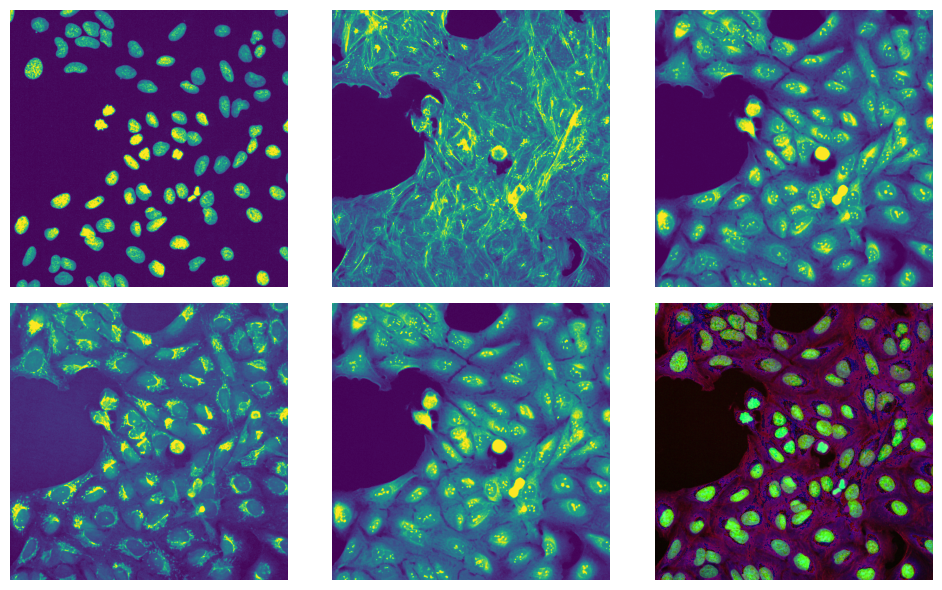

In [17]:
plot_example(dt[0]);

In [51]:
config = ViTMAEConfig(
    image_size=512,
    patch_size=32,
    num_channels=5,
    mask_ratio=0.75,
    norm_pix_loss=True,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    decoder_num_attention_heads=8,
    decoder_hidden_size=512,
    decoder_num_hidden_layers=4,
    decoder_intermediate_size=2048,
    hidden_dropout_prob=0.0,
    attention_probs_dropout_prob=0.0,
)

In [52]:
model = ViTMAEForPreTraining(config)

In [20]:
model

ViTMAEForPreTraining(
  (vit): ViTMAEModel(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): ViTMAEPatchEmbeddings(
        (projection): Conv2d(5, 768, kernel_size=(16, 16), stride=(16, 16))
      )
    )
    (encoder): ViTMAEEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTMAELayer(
          (attention): ViTMAEAttention(
            (attention): ViTMAESelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTMAEIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bi

In [21]:
dl = module.val_dataloader(batch_size=4)

In [22]:
b = next(iter(dl))

In [23]:
b.shape

torch.Size([4, 5, 512, 512])

In [134]:
model.patchify(b).shape

torch.Size([4, 1024, 1280])

In [53]:
res = model.forward(b)

In [25]:
res

ViTMAEForPreTrainingOutput(loss=tensor(1.2122, grad_fn=<DivBackward0>), logits=tensor([[[ 0.5856,  0.1755,  0.0266,  ...,  0.4880, -0.1824,  0.1279],
         [ 0.8677, -0.2068, -0.0218,  ..., -0.1248, -0.5624,  0.9790],
         [ 0.5583,  0.3723,  0.0071,  ...,  0.3172, -0.2896,  0.0478],
         ...,
         [ 0.6371,  0.3246, -0.6245,  ..., -0.0255,  0.5360,  0.2189],
         [ 0.6812,  0.3785, -0.5123,  ...,  0.0455,  0.6005,  0.2641],
         [ 0.7028,  0.4828, -0.3742,  ...,  0.0823,  0.6276,  0.3582]],

        [[ 0.8354, -0.3097, -0.0399,  ..., -0.0931, -0.4590,  0.9322],
         [ 0.5996,  0.2348,  0.1052,  ...,  0.5791, -0.2620,  0.3118],
         [ 0.7928, -0.0844, -0.0813,  ..., -0.2281, -0.5586,  0.9347],
         ...,
         [ 0.6241,  0.3345, -0.6364,  ..., -0.0289,  0.5326,  0.2246],
         [ 0.6674,  0.3883, -0.5240,  ...,  0.0414,  0.5976,  0.2698],
         [ 0.6893,  0.4931, -0.3864,  ...,  0.0776,  0.6247,  0.3636]],

        [[ 0.8390, -0.3236, -0.0309, 

In [26]:
real_image = b[0]

In [66]:
def plot_example_pred(real, masked, pred):
    fig, axs = plt.subplots(6, 3, figsize=(12, 18))

    titles = ["Masked", "Reconstructed", "Real"]
    tensors = [masked, pred, real]

    for j in range(3):
        ex = tensors[j].detach().cpu()

        if ex.dtype == torch.float32:
            ex = (ex.numpy() * 255).astype(np.uint8)

        for i in range(6):
            ax = axs[i, j]
            if i == 0:
                ch1 = ex[0]
                ch2 = ((ex[1] + ex[3]) / 2).astype(np.uint8)
                ch3 = ((ex[2] + ex[4]) / 2).astype(np.uint8)
                new = np.stack([ch2, ch1, ch3], axis=-1, dtype=np.uint8)
                ax.imshow(new)
                ax.axis("off")
                ax.set(title=titles[j])
            else:
                ax.imshow(ex[i - 1])
                ax.axis("off")

    fig.tight_layout()

    return fig

In [60]:
idx = 0

real_image = b[idx]

prediction = res.logits
pred_image = model.unpatchify(prediction)[idx].detach()

patches = model.patchify(b)
masks = res.mask.unsqueeze(-1).expand_as(patches)
masked_patches = patches * masks
masked_images = model.unpatchify(masked_patches)[idx]

In [67]:
plot_example_pred(real_image, masked_images, pred_image);

In [48]:
masked_images.shape, pred_image.shape, real_image.shape

(torch.Size([5, 512, 512]),
 torch.Size([5, 512, 512]),
 torch.Size([5, 512, 512]))

In [46]:
masks.unsqueeze(-1).expand_as(patches)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 

In [37]:
patches.shape,

torch.Size([4, 1024, 1280])

In [ ]:
masked_image

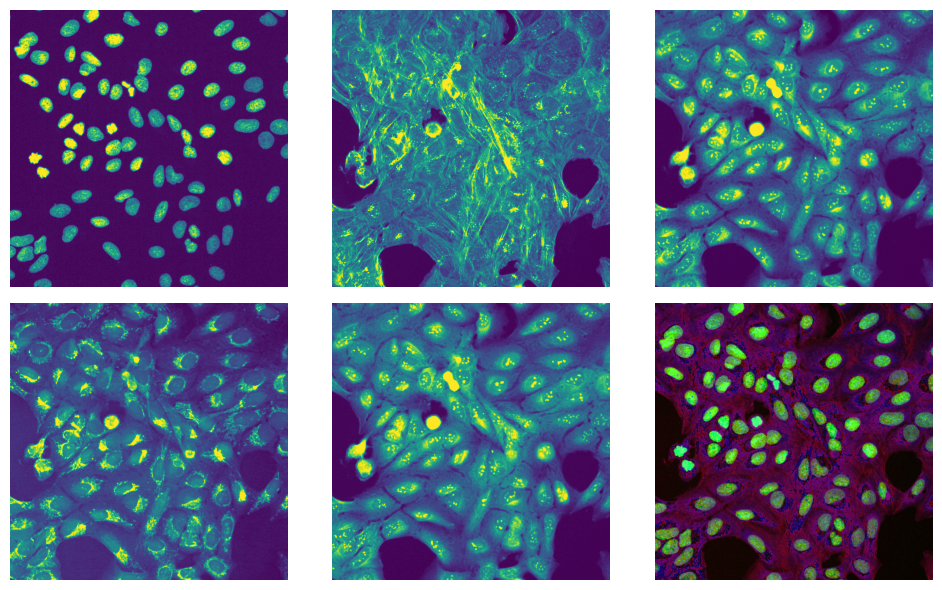

In [28]:
plot_example(real_image);

In [141]:
predicted_images = model.unpatchify(res.logits)

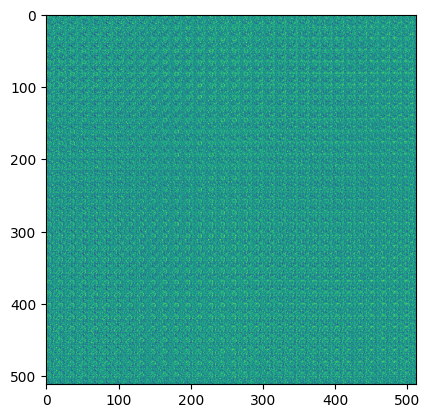

In [145]:
plt.imshow(predicted_images[0, 0].detach().numpy())

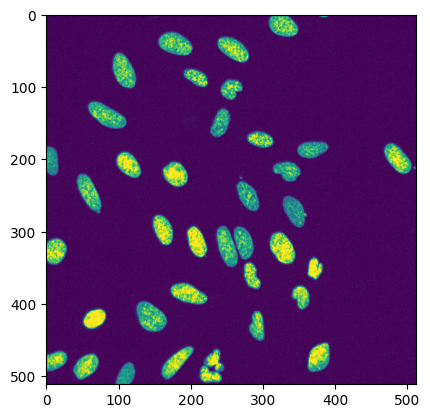

In [146]:
plt.imshow(b[0, 0].detach().numpy())

In [120]:
res2 = model.vit.forward(b)

In [123]:
res2

ViTMAEModelOutput(last_hidden_state=tensor([[[-0.9129,  0.1795,  1.8769,  ...,  0.2141, -2.0225,  2.2234],
         [-0.3982, -0.3086,  0.2332,  ..., -0.1909, -0.3006,  2.3779],
         [-0.5009, -0.2678,  0.7774,  ..., -0.2625, -1.4036,  2.8213],
         ...,
         [ 0.0441, -0.6050,  0.8915,  ...,  0.2421,  0.0300,  2.3827],
         [-0.7210, -0.9603,  0.3414,  ..., -0.0444, -1.1549,  2.8326],
         [ 0.0899,  0.1232,  1.0043,  ..., -0.5704, -0.5075,  2.6828]],

        [[-0.8049,  0.1136,  1.7544,  ...,  0.1049, -2.0348,  2.3367],
         [ 0.6837, -1.1833,  0.6290,  ..., -0.0365, -0.3241,  3.1562],
         [-0.3283, -0.2029,  0.1426,  ...,  0.5026, -1.0708,  2.6350],
         ...,
         [ 0.9290, -0.0477,  2.5215,  ..., -0.1107, -1.1113,  3.1014],
         [-0.0743, -1.1352,  1.5459,  ..., -0.0577, -0.3441,  2.7616],
         [ 0.2837, -0.0622,  0.6703,  ..., -0.3402, -0.3264,  3.3815]],

        [[-0.4873,  0.1361,  1.4704,  ...,  0.0301, -2.1645,  2.4606],
         

In [127]:
res.logits.shape

torch.Size([4, 1024, 1280])